###Classifying Surnames with a Convolutional Neural Network###

###Prepare Data###

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Install library for read pdf file
!pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 31.9 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import pandas as pd
import string
import requests
import numpy as np
import matplotlib.pyplot as plt
import random

import pdfplumber
from io import BytesIO
import collections

from argparse import Namespace
from collections import Counter
import json
import os
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

In [ ]:
# Download data for training
file_id = "1iDS97M7M4PB5JeBB3I0nfjTqAQHXPZXw"
url = f"https://drive.google.com/uc?export=download&id={file_id}"

output_file = "surnames.csv"

response = requests.get(url)
if response.status_code == 200:
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print(f"File downloaded successfully as {output_file}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

File downloaded successfully as surnames.csv


In [ ]:
# Defined args for prepare data
args = Namespace(
    raw_dataset_csv="surnames.csv",
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_munged_csv="surnames_with_splits.csv",
    seed=1337
)

In [ ]:
# Read trainging data
data = pd.read_csv("surnames.csv")
data.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


In [ ]:
# Check average number of data for all nationality
print("Min: ", data.groupby('nationality').count().min()['surname'])
print("Max: ", data.groupby('nationality').count().max()['surname'])
print("Mean: ", data.groupby('nationality').count().mean()['surname'])

Min:  55
Max:  2972
Mean:  610.0


<Axes: xlabel='nationality'>

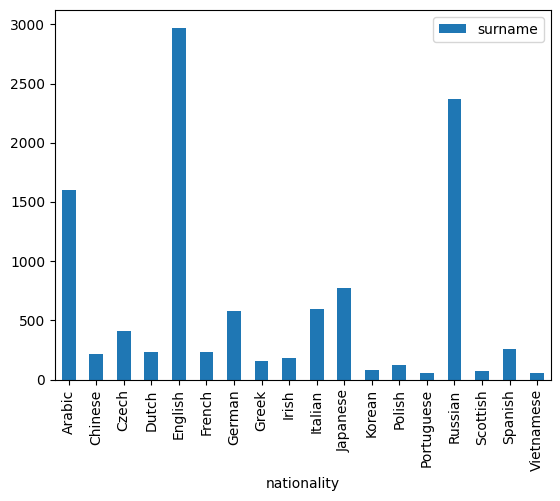

In [ ]:
# Plot number of data for each nationality to check the difference
data.groupby('nationality').count().plot(kind='bar')

In [ ]:
# Download data of Thai nationality for training
pdf_url = "https://www.rcst.or.th/web-upload/filecenter/1-3041.pdf"

thai_surname_list = []
response = requests.get(pdf_url)
pdf_bytes = BytesIO(response.content)

thai_surname_list = []
with pdfplumber.open(pdf_bytes) as pdf:
    for page in pdf.pages:
        text = page.extract_text()
        name_list = text.split("\n")[1:]
        for j in range(len(name_list)):
          text_list = name_list[j].split()
          if len(text_list) == 6 and len(text_list[5]) >= 3:
            thai_surname_list.append(text_list[5].capitalize())
thai_surname_list[:10]

['Poshakrishna',
 'Chartikauans',
 'Suwanwela',
 'Keokarn',
 'Vajrabukka',
 'Koonvisal',
 'Tantiwongse',
 'Sindhvananda',
 'Viseshakul',
 'Rukspollmuang']

In [ ]:
# Combine given data and thai nationality data
combine_list = data['surname'].to_list() + thai_surname_list
print("Before shuffle:")
print(combine_list[:10])

# Shuffle data
random.shuffle(combine_list)
print("After shuffle:")
print(combine_list[:10])

Before shuffle:
['Woodford', 'Coté', 'Kore', 'Koury', 'Lebzak', 'Obinata', 'Rahal', 'Zhuan', 'Acconci', 'Mifsud']
After shuffle:
['Gillam', 'Yangyuen', 'Ruiz', 'Juravlenko', 'Stapanavatr', 'Wirnhier', 'Sarraf', 'Singleton', 'Asghar', 'Simon']


In [ ]:
# Create DataFrame
df = pd.DataFrame(combine_list, columns=['surname'])

In [ ]:
# Mapping nationality
for i in range(len(df)):
  if df.loc[i, 'surname'] in thai_surname_list:
    df.loc[i, 'nationality'] = 'Thai'
  else:
    df.loc[i, 'nationality'] = data[data['surname'] == df.loc[i, 'surname']]['nationality'].values[0]
df.head()

,surname,nationality
0,Gillam,English
1,Yangyuen,Thai
2,Ruiz,Spanish
3,Juravlenko,Russian
4,Stapanavatr,Thai


In [ ]:
# Deduplicate data
print("Rows before: ", len(df))
df = df.drop_duplicates(keep='last')
print("Rows after: ", len(df))

Rows before:  13960
Rows after:  11900


In [ ]:
# Check average number of data for all nationality
print("Min: ", df.groupby('nationality').count().min()['surname'])
print("Max: ", df.groupby('nationality').count().max()['surname'])
print("Mean: ", df.groupby('nationality').count().mean()['surname'])

Min:  43
Max:  2860
Mean:  626.3157894736842


<Axes: xlabel='nationality'>

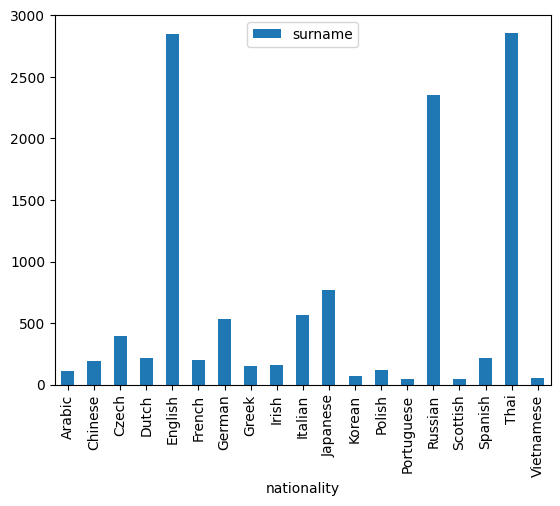

In [ ]:
# Plot number of data for each nationality to check the difference
df.groupby('nationality').count().plot(kind='bar')

In [ ]:
# Splitting train by nationality
# Create dict
by_nationality = collections.defaultdict(list)
for _, row in df.iterrows():
    by_nationality[row.nationality].append(row.to_dict())

In [ ]:
by_nationality['Thai']

[{'surname': 'Yangyuen', 'nationality': 'Thai'},
 {'surname': 'Stapanavatr', 'nationality': 'Thai'},
 {'surname': 'Thavichaigarn', 'nationality': 'Thai'},
 {'surname': 'Pipatnarapong', 'nationality': 'Thai'},
 {'surname': 'Purasiri', 'nationality': 'Thai'},
 {'surname': 'Putthkayon', 'nationality': 'Thai'},
 {'surname': 'Unchinapa', 'nationality': 'Thai'},
 {'surname': 'Taecholarn', 'nationality': 'Thai'},
 {'surname': 'Aitphawin', 'nationality': 'Thai'},
 {'surname': 'Kosakarn', 'nationality': 'Thai'},
 {'surname': 'Poomee', 'nationality': 'Thai'},
 {'surname': 'Yoongtong', 'nationality': 'Thai'},
 {'surname': 'Meesiri', 'nationality': 'Thai'},
 {'surname': 'Chaiwijit', 'nationality': 'Thai'},
 {'surname': 'Orannapalai', 'nationality': 'Thai'},
 {'surname': 'Girdwichai', 'nationality': 'Thai'},
 {'surname': 'Jirasirirojanakorn', 'nationality': 'Thai'},
 {'surname': 'Witoonchart', 'nationality': 'Thai'},
 {'surname': 'Wongviwatsaree', 'nationality': 'Thai'},
 {'surname': 'Yensudchai', 

In [ ]:
# Create split data
final_list = []
np.random.seed(args.seed)
for _, item_list in sorted(by_nationality.items()):
    np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_proportion*n)  # 0.7
    n_val = int(args.val_proportion*n) # 0.15
    n_test = int(args.test_proportion*n) # 0.15

    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'

    # Add to final list
    final_list.extend(item_list)

In [ ]:
# Write split data to file
final_surnames = pd.DataFrame(final_list)

In [ ]:
final_surnames.head()

,surname,nationality,split
0,Bata,Arabic,train
1,Hanania,Arabic,train
2,Haddad,Arabic,train
3,Atiyeh,Arabic,train
4,Morcos,Arabic,train


In [ ]:
final_surnames.split.value_counts()

,count
split,
train,8320
test,1803
val,1777


In [ ]:
final_surnames.groupby(['nationality','split']).count()

surname
nationality split         
Arabic      test        17
            train       75
            val         16
Chinese     test        30
            train      133
            val         28
Czech       test        60
            train      273
            val         58
Dutch       test        34
            train      151
            val         32
English     test       428
            train     1992
            val        426
French      test        31
            train      140
            val         30
German      test        81
            train      373
            val         79
Greek       test        23
            train      105
            val         22
Irish       test        25
            train      114
            val         24
Italian     test        86
            train      398
            val         85
Japanese    test       117
            train      540
            val        115
Korean      test        11
            train       46
            val         10
Polish      test        18
            train       80
            val         17
Portuguese  test         7
            train       30
            val          6
Russian     test       354
            train     1647
            val        353
Scottish    test         8
            train       33
            val          7
Spanish     test        34
            train      152
            val         32
Thai        test       430
            train     2001
            val        429
Vietnamese  test         9
            train       37
            val          8

In [ ]:
# Write munged data to CSV
final_surnames.to_csv(args.output_munged_csv, index=False)

###Vocaburay Class###

In [ ]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token
                              for token, idx in self._token_to_idx.items()}

        self._add_unk = add_unk
        self._unk_token = unk_token

        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token)


    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx,
                'add_unk': self._add_unk,
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        try:
            index = self._token_to_idx[token]
        except KeyError:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index

    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary

        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token
          or the UNK index if token isn't present.

        Args:
            token (str): the token to look up
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary)
              for the UNK functionality
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index

        Args:
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

###Vectorizer###

In [ ]:
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, surname_vocab, nationality_vocab, max_surname_length):
        """
        Args:
            surname_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
            max_surname_length (int): the length of the longest surname
        """
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab
        self._max_surname_length = max_surname_length

    def vectorize(self, surname):
        """
        Args:
            surname (str): the surname
        Returns:
            one_hot_matrix (np.ndarray): a matrix of one-hot vectors
        """

        one_hot_matrix_size = (len(self.surname_vocab), self._max_surname_length)
        one_hot_matrix = np.zeros(one_hot_matrix_size, dtype=np.float32)

        for position_index, character in enumerate(surname):
            character_index = self.surname_vocab.lookup_token(character)
            one_hot_matrix[character_index][position_index] = 1

        return one_hot_matrix

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe

        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        surname_vocab = Vocabulary(unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)
        max_surname_length = 0

        for index, row in surname_df.iterrows():
            max_surname_length = max(max_surname_length, len(row.surname))
            for letter in row.surname:
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)

        return cls(surname_vocab, nationality_vocab, max_surname_length)

    @classmethod
    def from_serializable(cls, contents):
        surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
        nationality_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])
        return cls(surname_vocab=surname_vocab, nationality_vocab=nationality_vocab,
                   max_surname_length=contents['max_surname_length'])

    def to_serializable(self):
        return {'surname_vocab': self.surname_vocab.to_serializable(),
                'nationality_vocab': self.nationality_vocab.to_serializable(),
                'max_surname_length': self._max_surname_length}

###Dataset Class###

In [ ]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            name_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.surname_df = surname_df
        self._vectorizer = vectorizer
        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        # Class weights
        class_counts = surname_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)


    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch

        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer.
        Used in the case in the vectorizer has been cached for re-use

        Args:
            surname_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(surname_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file

        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of SurnameDataset
        """
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json

        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets

        Args:
            index (int): the index to the data point
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        surname_matrix = \
            self._vectorizer.vectorize(row.surname)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_surname': surname_matrix,
                'y_nationality': nationality_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset

        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size


def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

###Classifier###

In [ ]:
class SurnameClassifier(nn.Module):
    def __init__(self, initial_num_channels, num_classes, num_channels):
        """
        Args:
            initial_num_channels (int): size of the incoming feature vector
            num_classes (int): size of the output prediction vector
            num_channels (int): constant channel size to use throughout network
        """
        super(SurnameClassifier, self).__init__()

        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=initial_num_channels,
                      out_channels=num_channels, kernel_size=3),
            nn.ELU(),

            nn.Conv1d(in_channels=num_channels, out_channels=num_channels,
                      kernel_size=3, stride=2),
            nn.ELU(),

            nn.Conv1d(in_channels=num_channels, out_channels=num_channels,
                      kernel_size=3, stride=2),
            nn.ELU(),

            nn.Conv1d(in_channels=num_channels, out_channels=num_channels,
                      kernel_size=3),
            nn.ELU()
        )
        self.fc = nn.Linear(num_channels, num_classes)

    def forward(self, x_surname, apply_softmax=False):
        """The forward pass of the classifier

        Args:
            x_surname (torch.Tensor): an input data tensor.
                x_surname.shape should be (batch, initial_num_channels, max_surname_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        features = self.convnet(x_surname).squeeze(dim=2)

        prediction_vector = self.fc(features)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

###Training###

In [ ]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

In [ ]:
def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [ ]:
def compute_accuracy(y_pred, y_target):
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [ ]:
if not os.path.isdir("model_storage"):
  !mkdir model_storage

args = Namespace(
    # Data and Path information
    surname_csv="surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage",
    # Model hyper parameters
    hidden_dim=100,
    num_channels=256,
    # Training hyper parameters
    seed=1337,
    learning_rate=0.001,
    batch_size=128,
    num_epochs=200,
    early_stopping_criteria=5,
    dropout_p=0.1,
    # Runtime options
    cuda=False,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
    catch_keyboard_interrupt=True
)


if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)

    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/vectorizer.json
	model_storage/model.pth
Using CUDA: False


###Load Dataset, Vectorizer, Model###

In [ ]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

classifier = SurnameClassifier(initial_num_channels=len(vectorizer.surname_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               num_channels=args.num_channels)

classifer = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(weight=dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

In [ ]:
dataset[0]

{'x_surname': array([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'y_nationality': 0}

In [ ]:
dataset[0]['x_surname'].shape

(82, 20)

In [ ]:
print(vectorizer.surname_vocab)
print(vectorizer.nationality_vocab)
print(vectorizer._max_surname_length)

<Vocabulary(size=82)>
<Vocabulary(size=19)>
20


In [ ]:
classifier

SurnameClassifier(
  (convnet): Sequential(
    (0): Conv1d(82, 256, kernel_size=(3,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): Conv1d(256, 256, kernel_size=(3,), stride=(2,))
    (3): ELU(alpha=1.0)
    (4): Conv1d(256, 256, kernel_size=(3,), stride=(2,))
    (5): ELU(alpha=1.0)
    (6): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (7): ELU(alpha=1.0)
  )
  (fc): Linear(in_features=256, out_features=19, bias=True)
)

In [ ]:
epoch_bar = tqdm(desc='training routine',
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size),
                          position=1,
                          leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size),
                        position=1,
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_surname'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc,
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_surname'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc,
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/200 [00:00<?, ?it/s]

split=train:   0%|          | 0/65 [00:00<?, ?it/s]

split=val:   0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset,
                                   batch_size=args.batch_size,
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_surname'])

    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_nationality'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [ ]:
print("Train Accuracy: {}".format(train_state['train_acc'][-1]))
print("Test loss: {}".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Train Accuracy: 70.40865384615385
Test loss: 1.981505002294268
Test Accuracy: 59.095982142857146


In [ ]:
print("Train Max Accuracy: {}".format(max(train_state['train_acc'])))
print("At trainging epoch: {}".format(train_state['train_acc'].index(max(train_state['train_acc']))))

Train Max Accuracy: 70.42067307692311
At trainging epoch: 26


###Inference###

In [ ]:
def predict_nationality(surname, classifier, vectorizer):
    """Predict the nationality from a new surname

    Args:
        surname (str): the surname to classifier
        classifier (SurnameClassifer): an instance of the classifier
        vectorizer (SurnameVectorizer): the corresponding vectorizer
    Returns:
        a dictionary with the most likely nationality and its probability
    """
    vectorized_surname = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(0)
    result = classifier(vectorized_surname, apply_softmax=True)

    probability_values, indices = result.max(dim=1)
    index = indices.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)
    probability_value = probability_values.item()

    return {'nationality': predicted_nationality, 'probability': probability_value}

In [ ]:
def predict_topk_nationality(surname, classifier, vectorizer, k=5):
    """Predict the top K nationalities from a new surname

    Args:
        surname (str): the surname to classifier
        classifier (SurnameClassifer): an instance of the classifier
        vectorizer (SurnameVectorizer): the corresponding vectorizer
        k (int): the number of top nationalities to return
    Returns:
        list of dictionaries, each dictionary is a nationality and a probability
    """

    vectorized_surname = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    prediction_vector = classifier(vectorized_surname, apply_softmax=True)
    probability_values, indices = torch.topk(prediction_vector, k=k)

    # returned size is 1,k
    probability_values = probability_values[0].detach().numpy()
    indices = indices[0].detach().numpy()

    results = []
    for kth_index in range(k):
        nationality = vectorizer.nationality_vocab.lookup_index(indices[kth_index])
        probability_value = probability_values[kth_index]
        results.append({'nationality': nationality,
                        'probability': probability_value})
    return results

###Prepare Inference Data###

***RUSSIAN FEDERATION***

- Mr O.P. CHESTNOV, Deputy Director, Department of International Cooperation and Public
Relations, Ministry of Health and Social Development, Moscow
- Mr A. PIROGOV, Deputy Permanent Representative, Geneva
- Mr V.A. NEBENZYA, Deputy Director, Department of International Organizations, Ministry of
Foreign Affairs, Moscow
- Ms E.B. EZHLOVA, Deputy Head, Russian Consumer Protection Agency, Moscow
- Ms A.V. KOROTKOVA, Deputy Director, Central Research Institute for Health Management and
Information Systems, Moscow
- Mr J.A. KIRILLOV, Head of Unit, Department of Pharmaceuticals, Human Welfare, Science and
Education, Ministry of Health and Social Development, Moscow

***FRANCE***
- M. J.-M. RIPERT, Ambassadeur, Représentant permanent, Genève
- Dr J.-B. BRUNET, Chef, Cellule des Affaires européennes et internationales, Direction générale
de la Santé, Ministère de la Santé et des Solidarités, Paris
- M. L. CONTINI, Sous-Directeur aux Affaires économiques, Ministère des Affaires étrangères,
Paris
- Mme B. ARTHUR, Délégation aux Affaires européennes et internationales, Ministère de la
Santé et des Solidarités, Paris
- M. G. DELVALLÉE, Direction des Nations Unies et des Organisations internationales,
Ministère des Affaires étrangères, Paris

***THAILAND***
- Dr SUWIT WIBULPOLPRASERT, Senior Public Health Officer, Ministry of Public Health, Bangkok
Alternates
- Mr CHAIYONG SATJIPANON, Ambassador, Permanent Representative, Geneva
- Dr VIROJ TANGCHAROENSATHIEN, Senior Policy and Plan Analyst, Bureau of Policy and
Strategy, Ministry of Public Health, Bangkok
Advisers
- Ms WARANYA TEOKUL, Policy and Plan Analyst, Office of the National Economic and
Social Development Board, Bangkok
- Dr SOPIDA CHAVANICHKUL, Director, International Health Group, Bureau of Policy and
Strategy, Ministry of Public Health, Bangkok

***GREECE***
- Mr T. KRIEKOUKIS, Ambassador, Permanent Representative, Geneva
- Mr A. CAMBITSIS, Minister-Counsellor, Permanent Mission, Geneva
- Ms A. DAMIGOU, Counsellor (Health Affairs), Permanent Mission, Geneva
- Ms S. KYRIAKOU, Attaché, Permanent Mission, Geneva

***JAPAN***
- Dr H. SHINOZAKI, President, National Institute of Public Health, Tokyo
Alternates
- Mr Y. IWABUCHI, Director, International Affairs Planning Office, Ministry of Health, Labour
and Welfare, Tokyo
- Dr H. INOUE, Deputy Director, International Affairs Division, Ministry of Health, Labour and
Welfare, Tokyo
- Ms M. IMAI, Deputy Director, International Affairs Division, Ministry of Health, Labour and
Welfare, Tokyo
- Dr S. NODA, Deputy Director, International Affairs Division, Ministry of Health, Labour and
Welfare, Tokyo

***POLAND***
- Mr A. MISZTAL, Minister Counsellor, Deputy Permanent Representative, Geneva
- Ms R. LEMIESZEWSKA, Counsellor, Permanent Mission, Geneva
- Ms D. MARKIEWICZ-ZEMKE, Permanent Mission, Geneva

***ITALY***
- Dr F. CICOGNA, Direction générale des Relations internationales, Ministère de la Santé, Rome
- Mme L. FIORI, Premier Conseiller, Mission permanente, Genève
- Mme V. RUSSO, Expert (Coopération technique), Mission permanente, Genève
- Mme M.P. RIZZO, Direction générale de la Coopération au Développement, Ministère des Affaires
étrangères, Rome

***GERMANY***
- Mr M. STEINER, Ambassador, Permanent Representative, Geneva
- Ms B. SIEFKER-EBERLE, Minister, Deputy Permanent Representative, Geneva
- Mr M. DEBRUS, Head of Division, Federal Ministry of Health, Bonn
- Dr I. VON VOSS, Counsellor, Permanent Mission, Geneva
- Dr A. BRANDRUP-LUKANOW, Senior Adviser on Health, Education and Social Protection,
German Technical Cooperation (GTZ), Eschborn

***DEMOCRATIC PEOPLE’S REPUBLIC OF KOREA***
- Mr JANG IL HUN, Counsellor, Permanent Mission, Geneva

***VIET NAM***
- Mrs LE THI THU HA, Deputy Director, Department of International Cooperation, Ministry of Health
Hanoi
(Alternate)
- Mr PHAM HONG NGA, Counsellor, Permanent Mission, Geneva

***SPAIN***
- Sr. J.A. MARCH PUJOL, Embajador, Representante Permanente, Ginebra
- Sr. G. LÓPEZ MAC-LELLAN, Consejero, Misión Permanente, Ginebra

Reference: https://apps.who.int/gb/ebwha/pdf_files/EB117-REC2/R2-lom.pdf

In [ ]:
inference_data = {
    "CHESTNOV": "Russian",
    "PIROGOV": "Russian",
    "NEBENZYA": "Russian",
    "EZHLOVA": "Russian",
    "KOROTKOVA": "Russian",
    "KIRILLOV": "Russian",
    "RIPERT": "French",
    "BRUNET": "French",
    "CONTINI": "French",
    "ARTHUR": "French",
    "DELVALLÉE": "French",
    "WIBULPOLPRASERT": "Thai",
    "SATJIPANON": "Thai",
    "TANGCHAROENSATHIEN": "Thai",
    "TEOKUL": "Thai",
    "CHAVANICHKUL": "Thai",
    "KRIEKOUKIS": "Greek",
    "CAMBITSIS": "Greek",
    "DAMIGOU": "Greek",
    "KYRIAKOU": "Greek",
    "SHINOZAKI": "Japanese",
    "IWABUCHI": "Japanese",
    "INOUE": "Japanese",
    "IMAI": "Japanese",
    "NODA": "Japanese",
    "MISZTAL": "Polish",
    "LEMIESZEWSKA": "Polish",
    "MARKIEWICZ-ZEMKE": "Polish",
    "CICOGNA": "Italian",
    "FIORI": "Italian",
    "RUSSO": "Italian",
    "RIZZO": "Italian",
    "STEINER": "German",
    "SIEFKER-EBERLE": "German",
    "DEBRUS": "German",
    "VON VOSS": "German",
    "BRANDRUP-LUKANOW": "German",
    "JANG": "Korean",
    "LE THI THU HA": "Vietnamese",
    "PHAM": "Vietnamese",
    "MARCH PUJOL": "Spanish",
    "LÓPEZ MAC-LELLAN": "Spanish"
}

inference_df = pd.DataFrame(list(inference_data.items()), columns=["surname", "nationality"])
inference_df["surname"] = inference_df["surname"].str.capitalize()
inference_df.head()

,surname,nationality
0,Chestnov,Russian
1,Pirogov,Russian
2,Nebenzya,Russian
3,Ezhlova,Russian
4,Korotkova,Russian


In [ ]:
classifier = classifier.cpu()
k = 5

correct = 0
for i in range(len(inference_df)):
    surname = inference_df.loc[i, "surname"]
    nationality_actual = inference_df.loc[i, "nationality"]
    print("Surname: ", surname)
    print("Actual: ", nationality_actual)

    nationality_pred = predict_nationality(surname, classifier, vectorizer)
    print("Predict: {} (p={:0.2f})".format(nationality_pred['nationality'],
                                  nationality_pred['probability']))
    if nationality_pred['nationality'] == nationality_actual:
        correct += 1

    if k > len(vectorizer.nationality_vocab):
        print("Sorry! That's more than the # of nationalities we have.. defaulting you to max size :)")
        k = len(vectorizer.nationality_vocab)

    nationality_pred_top_k = predict_topk_nationality(surname, classifier, vectorizer, k=k)

    print("\nTop {} predictions:".format(k))
    print("===================")
    for prediction in nationality_pred_top_k:
        print("{}: {} (p={:0.2f})".format(surname,
                                        prediction['nationality'],
                                        prediction['probability']))

    print("======================================\n")

Surname:  Chestnov
Actual:  Russian
Predict: Russian (p=0.98)

Top 5 predictions:
Chestnov: Russian (p=0.98)
Chestnov: Czech (p=0.01)
Chestnov: Scottish (p=0.00)
Chestnov: Thai (p=0.00)
Chestnov: English (p=0.00)

Surname:  Pirogov
Actual:  Russian
Predict: Russian (p=0.84)

Top 5 predictions:
Pirogov: Russian (p=0.84)
Pirogov: Czech (p=0.14)
Pirogov: Thai (p=0.01)
Pirogov: English (p=0.00)
Pirogov: Italian (p=0.00)

Surname:  Nebenzya
Actual:  Russian
Predict: Italian (p=0.64)

Top 5 predictions:
Nebenzya: Italian (p=0.64)
Nebenzya: Spanish (p=0.29)
Nebenzya: Greek (p=0.04)
Nebenzya: French (p=0.01)
Nebenzya: Polish (p=0.00)

Surname:  Ezhlova
Actual:  Russian
Predict: Czech (p=0.71)

Top 5 predictions:
Ezhlova: Czech (p=0.71)
Ezhlova: Russian (p=0.24)
Ezhlova: Italian (p=0.04)
Ezhlova: Polish (p=0.00)
Ezhlova: English (p=0.00)

Surname:  Korotkova
Actual:  Russian
Predict: Czech (p=0.75)

Top 5 predictions:
Korotkova: Czech (p=0.75)
Korotkova: Thai (p=0.14)
Korotkova: Russian (p=0.09

In [ ]:
print("======== Inference ========")
print("Correct: {}".format(correct))
print("Total: {}".format(len(inference_df)))
print("Accuracy: {}".format(correct/len(inference_df)*100))

======== Inference ========
Correct: 18
Total: 42
Accuracy: 42.857142857142854
